In [1]:
import os
import re
import math
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Get the user's home directory (e.g., 'C:\Users\user')
DATA_DIR = r"C:\Users\ferit\MLPC2025_dataset"

In [3]:
# Load metadata
metadata = pd.read_csv(os.path.join(DATA_DIR, 'metadata.csv'))
metadata.set_index('filename', inplace=True)

## Task 3: Audio Features

### Task 3 (a): Feature Selection

In [4]:
# High computational effort!!!

In [5]:
# Loading the Audio Features
audio_features = {}
for idx, row in metadata.iterrows():
    path_to_feature_file = os.path.join(DATA_DIR, 'audio_features', idx.replace('mp3', 'npz'))
    audio_features[idx] = np.load(path_to_feature_file)['embeddings']

In [6]:
# Print number of feature files
print(f"{'Number of feature files: ':<30}{len(audio_features)}")

Number of feature files:      9026


In [7]:
# Sample Feature Tensor
feature_tensor = audio_features[metadata.index[0]]
print("Shape of feature tensor:", feature_tensor.shape)
print("Time steps: \t\t", feature_tensor.shape[0])
print("Feature vector size: \t", feature_tensor.shape[1])

Shape of feature tensor: (233, 768)
Time steps: 		 233
Feature vector size: 	 768


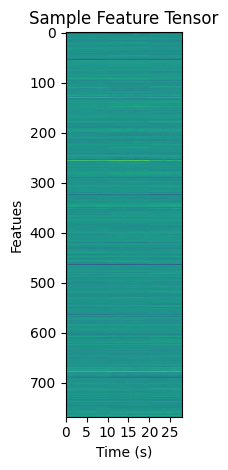

In [8]:
# Plot sample feature Tensor
plt.imshow(feature_tensor.T)
plt.xlabel("Time (s)")
plt.ylabel("Featues")
plt.xticks(np.arange(0, 30, 5) / 0.12, np.arange(0, 30, 5))
plt.title('Sample Feature Tensor')

plt.tight_layout()
plt.show()

In [9]:
# Feature Normalization
concatenated_feature_tensor = np.concatenate(list(audio_features.values()), axis=0)

In [10]:
print(f"{'Shape of all feature tensors concatenated: ':<30}{concatenated_feature_tensor.shape}")

Shape of all feature tensors concatenated: (1684753, 768)


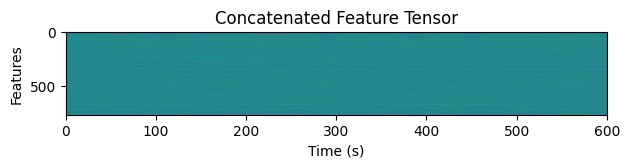

In [11]:
#Plot normalized concatenated Feature Tensor
plt.imshow(concatenated_feature_tensor[:5000].T)
plt.xlabel('Time (s)')
plt.ylabel('Features')
plt.xticks(np.arange(0,700,100)/0.12, np.arange(0,700,100))
plt.title('Concatenated Feature Tensor')

plt.tight_layout()
plt.show()

#### Feature Tensor Scaler

In [12]:
# High computational effort!!!

In [13]:
# Compute mean and standard deviation of the Feature Tensor
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(concatenated_feature_tensor)

del concatenated_feature_tensor

In [14]:
# scaler.fit(feature_tensor) computes mean and standard deviation of the feature tensor
# scaler.transform(feature_tensor) normalizes the feature center (centering the feature tensor)

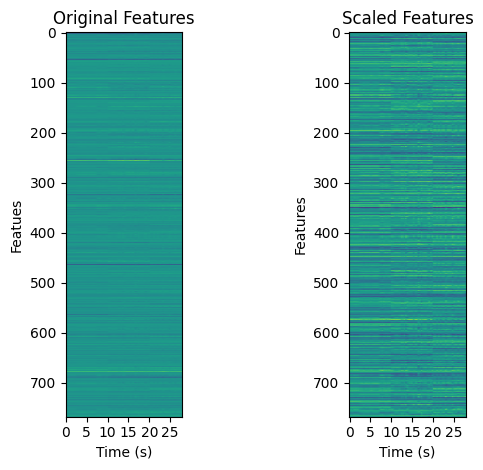

In [15]:
#Plot original and scaled Feature Tensor
fig, ax = plt.subplots(1, 2)

ax[0].imshow(feature_tensor.T)
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Featues")
ax[0].set_xticks(np.arange(0, 30, 5) / 0.12, np.arange(0, 30, 5))
ax[0].set_title('Original Features')

ax[1].imshow(scaler.transform(feature_tensor).T)
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Features')
ax[1].set_xticks(np.arange(0, 30, 5) / 0.12, np.arange(0, 30, 5))
ax[1].set_title('Scaled Features')

plt.tight_layout()
plt.show()

In [16]:
# Load Annotations
annotations = pd.read_csv(os.path.join(DATA_DIR, 'annotations.csv'))

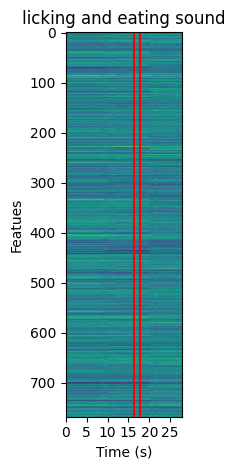

In [17]:
# Sample Temporal Annotations
i = 5
plt.imshow(scaler.transform(audio_features[annotations.iloc[i]['filename']]).T)
plt.title(annotations.iloc[i]['text'])
plt.axvline(x=annotations.iloc[i]['onset'] // 0.12, color='r')
plt.axvline(x=annotations.iloc[i]['offset'] // 0.12, color='r')
plt.xlabel("Time (s)")
plt.ylabel("Featues")
plt.xticks(np.arange(0,30,5)/0.12, np.arange(0,30,5))

plt.tight_layout()
plt.show()

#### Audio Feature Extractor for Annotated Regions

In [18]:
import math

def get_features_of_annotation(
    onset: float, 
    offset: float, 
    audio_features: np.ndarray, 
    scaler: preprocessing.StandardScaler = None
) -> np.ndarray:

    RESOLUTION = 0.12 # temporal resolution of the features is 120 ms
    start_idx = math.floor(onset / RESOLUTION)
    offset_idx = math.ceil(offset / RESOLUTION)
    
    audio_features = audio_features[start_idx:offset_idx, :]
    if scaler is not None:
        audio_features = scaler.transform(audio_features)    
    return audio_features.mean(axis=0)

#### Scaled Feature Tensor

In [19]:
# High computational effort!!!

In [20]:
X = np.zeros((len(annotations), 768))
for i, row in annotations.iterrows():
    X[i] = get_features_of_annotation(row['onset'], row['offset'], audio_features[row['filename']], scaler)

In [21]:
print("Audio Features of annotated regions:", X.shape)

Audio Features of annotated regions: (35826, 768)


#### Clustering the Audio Features

In [22]:
# Clustering the Audio Features
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=25, max_iter=300, random_state=14124).fit(X)
clusters = kmeans.predict(X)
annotations['clusters'] = clusters

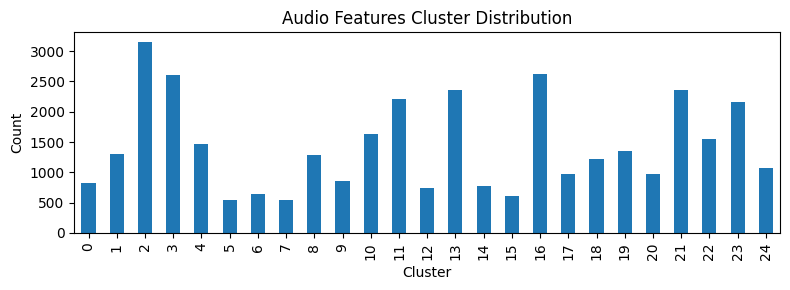

In [23]:
# Plot Audio Features Clustering
counts = annotations["clusters"].value_counts(sort=False).sort_index()
counts.plot(kind="bar", figsize=(8, 3))

plt.title('Audio Features Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

#### PCA Reduced Feature Tensor

In [24]:
# PCA dimensionality reduction with keeping 95% of the variance
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)

In [25]:
# Print PCA dimensionality reduction
print("="*80)
print("Audio Feature Analysis")
print("="*80)
print(f"{'Feature shape':<30}: {X.shape}")

print("\nDimensionality Reduction Results:")
print("-"*80)
print(f"{'Original features':<30}: {X.shape[1]}")
print(f"{'Reduced features':<30}: {X_reduced.shape[1]}")
print(f"{'Variance explained':<30}: {sum(pca.explained_variance_ratio_):>5.1%}")
print("-"*80)

Audio Feature Analysis
Feature shape                 : (35826, 768)

Dimensionality Reduction Results:
--------------------------------------------------------------------------------
Original features             : 768
Reduced features              : 193
Variance explained            : 95.0%
--------------------------------------------------------------------------------


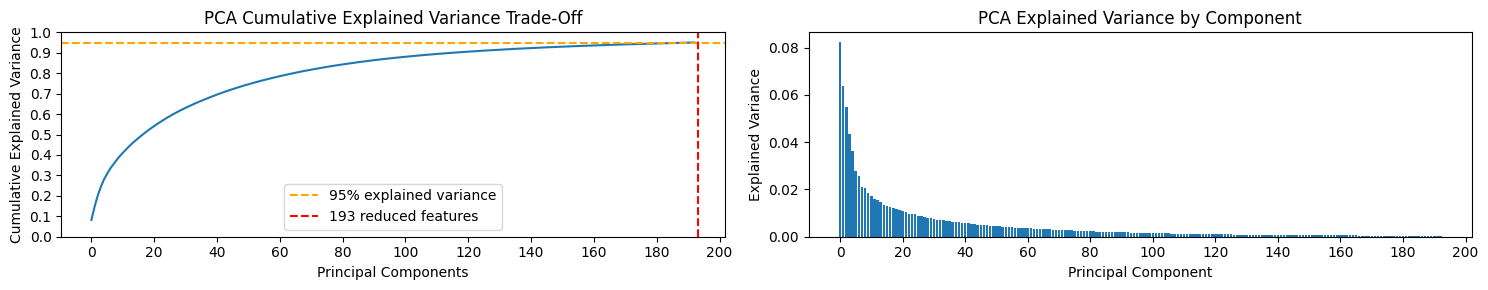

In [26]:
# Plot explained variance
plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('PCA Cumulative Explained Variance Trade-Off')
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(np.arange(0, int(X_reduced.shape[1]) + 20, 20))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axhline(y=0.95, color='orange', linestyle='--', label='95% explained variance')
plt.axvline(x=pca.n_components_, color='red', linestyle='--', label=f'{pca.n_components_:.0f} reduced features')
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)
plt.title('PCA Explained Variance by Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.xticks(np.arange(0, int(X_reduced.shape[1]) + 20, 20))

plt.tight_layout()
plt.show()

### Task 3 (b): Fixed-length Feature Extraction

In [27]:
# Load Data
metadata = pd.read_csv(os.path.join(DATA_DIR, 'metadata.csv'))
annotations = pd.read_csv(os.path.join(DATA_DIR, "annotations.csv"))
audio_features_dir = f"{DATA_DIR}/audio_features"

#### Process a single audio file

In [28]:
# Process a single audio file
def process_file(filename: str, scaler: StandardScaler = None) -> np.ndarray:    
    # Load features (shape: [time_steps, 768])
    feature_path = os.path.join(audio_features_dir, filename.replace(".mp3", ".npz"))
    features = np.load(feature_path)["embeddings"]
    total_steps = features.shape[0]
    
    # Get annotations for this file
    file_annots = annotations[annotations["filename"] == filename].sort_values("onset")
    
    # Extract annotated regions
    annotated_vectors = []
    for _, row in file_annots.iterrows():
        start = math.floor(row["onset"] / 0.12)
        end = math.ceil(row["offset"] / 0.12)
        region = features[start:end]
        if scaler is not None:
            region = scaler.transform(region)
        if len(region) > 0:
            annotated_vectors.append(np.mean(region, axis=0))  # Mean pooling
    
    # Extract silent regions between annotations
    silent_vectors = []
    prev_end = 0  # Start from beginning of file
    
    for _, row in file_annots.iterrows():
        current_start = math.floor(row["onset"] / 0.12)
        
        # Check for silent region before this annotation
        if current_start > prev_end:
            silent_region = features[prev_end:current_start]
            if len(silent_region) > 0:
                if scaler is not None:
                    silent_region = scaler.transform(silent_region)
                silent_vectors.append(np.mean(silent_region, axis=0))
        
        prev_end = math.ceil(row["offset"] / 0.12)
    
    # Check for silent region after last annotation
    if prev_end < total_steps:
        silent_region = features[prev_end:total_steps]
        if len(silent_region) > 0:
            if scaler is not None:
                silent_region = scaler.transform(silent_region)
            silent_vectors.append(np.mean(silent_region, axis=0))
    
    return np.array(annotated_vectors), np.array(silent_vectors)

In [29]:
# High computational effort!!!

In [30]:
# Process all files
all_annotated = []
all_silent = []

for filename in annotations["filename"].unique():
    annotated, silent = process_file(filename, scaler)

    # Dimension check
    if len(annotated) > 0:
        if annotated.ndim == 1:                   # region is 1D
            annotated = annotated[np.newaxis, :]  # convert to 2D (1, 768)
        all_annotated.append(annotated)

    if len(silent) > 0:
        if silent.ndim == 1:                      # region is 1D
            silent = silent[np.newaxis, :]        # convert to 2D (1, 768)
        all_silent.append(silent)

# Combine results
annotated_features = np.concatenate(all_annotated) if all_annotated else np.empty((0, 768))
silent_features = np.concatenate(all_silent) if all_silent else np.empty((0, 768))

In [31]:
# Print Fixed-length Feature Extraction Analysis
print("="*80)
print("Fixed-Length Feature Extraction Analysis")
print("="*80)
print(f"{'Extracted annotated regions':<30}: {len(annotated_features)}")
print(f"{'Extracted silent regions':<30}: {len(silent_features)}")
print("-"*80)
print(f"{'Annotated features shape':<30}: {annotated_features.shape}")
print(f"{'Silent features shape':<30}: {silent_features.shape}")
print("-"*80)

Fixed-Length Feature Extraction Analysis
Extracted annotated regions   : 35826
Extracted silent regions      : 16282
--------------------------------------------------------------------------------
Annotated features shape      : (35826, 768)
Silent features shape         : (16282, 768)
--------------------------------------------------------------------------------


In [32]:
# PCA dimensionality reduction with keeping 95% of the variance
pca = PCA(n_components=0.95)
annotated_reduced = pca.fit_transform(annotated_features)
silent_reduced = pca.fit_transform(silent_features)

In [33]:
# Print PCA dimensionality reduction
print("="*80)
print("PCA Dimensionality Reduction on Annotated & Silent Regions")
print("="*80)
print(f"{'Annotated Regions Feature Shape':<35}: {annotated_features.shape}")
print(f"{'Silent Regions Feature Shape':<35}: {silent_features.shape}")
print("\nDimensionality Reduction Results:")
print("-"*80)
print(f"{'Reduced Annotated Features':<35}: {annotated_reduced.shape[1]}")
print(f"{'Reduced Silent Features':<35}: {silent_reduced.shape[1]}")
print(f"{'Variance explained':<35}: {sum(pca.explained_variance_ratio_):>5.1%}")
print("-"*80)

PCA Dimensionality Reduction on Annotated & Silent Regions
Annotated Regions Feature Shape    : (35826, 768)
Silent Regions Feature Shape       : (16282, 768)

Dimensionality Reduction Results:
--------------------------------------------------------------------------------
Reduced Annotated Features         : 193
Reduced Silent Features            : 187
Variance explained                 : 95.0%
--------------------------------------------------------------------------------


### Task 3 (c): Clustering the Audio Features

In [34]:
# KMeans Clustering
kmeans = KMeans(n_clusters=25, max_iter=300, random_state=14124)

# Create separate DataFrames for each region type
annotated_df = pd.DataFrame(annotated_reduced)
silent_df = pd.DataFrame(silent_reduced)

# Clustering features for each region type
annotated_df['cluster'] = kmeans.fit_predict(annotated_reduced)
silent_df['cluster'] = kmeans.fit_predict(silent_reduced)

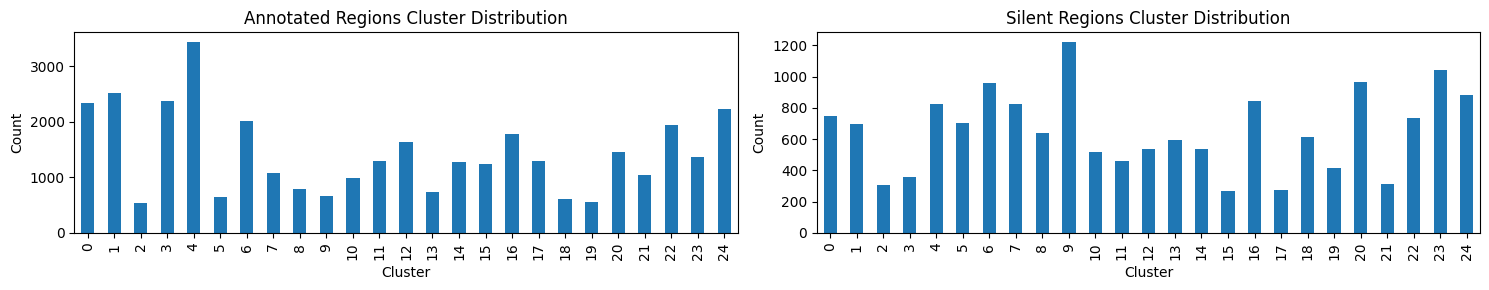

In [35]:
# Plotting Clustering Results
plt.figure(figsize=(15, 3))

# Annotated Clusters
plt.subplot(1, 2, 1)
counts_annotated = annotated_df['cluster'].value_counts(sort=False).sort_index()
counts_annotated.plot(kind='bar')
plt.title('Annotated Regions Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Count')

# Silent Clusters
plt.subplot(1, 2, 2)
counts_silent = silent_df['cluster'].value_counts(sort=False).sort_index()
counts_silent.plot(kind='bar')
plt.title('Silent Regions Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

#### Vizualize Audio Feature (PCA with n=2 & K-Means with n=25)

In [36]:
# Dimensionality reduction
n_dim=2
pca = PCA(n_components=n_dim)
X_PC2 = pca.fit_transform(annotated_features)

In [37]:
# Clustering
n_clusters = 25
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
X_clusters = kmeans.fit_predict(X_PC2)

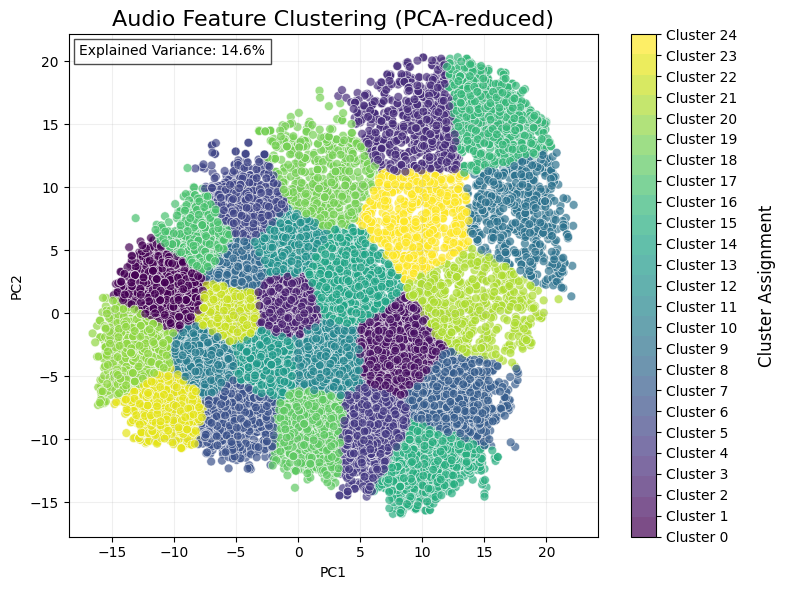

In [38]:
# Visualization
fig, ax = plt.subplots(figsize=(8, 6))
cmap = plt.cm.get_cmap('viridis', n_clusters)

# Plot points with cluster colors
scatter = ax.scatter(X_PC2[:, 0], X_PC2[:, 1],c=X_clusters, cmap=cmap,s=40, alpha=0.7, edgecolor='w', linewidth=0.5)

plt.title('Audio Feature Clustering (PCA-reduced)', fontsize=16)
plt.xlabel('PC1', fontsize=10)
plt.ylabel('PC2', fontsize=10)
plt.grid(alpha=0.2)

# Add colorbar
cbar = plt.colorbar(scatter, ticks=range(n_clusters))
cbar.set_label('Cluster Assignment', fontsize=12, labelpad=15)
cbar.ax.tick_params(labelsize=10)
cbar.set_ticklabels([f'Cluster {i}' for i in range(n_clusters)])

# Add explained variance ratio
plt.text(0.02, 0.98, 
         f"Explained Variance: {pca.explained_variance_ratio_.sum():.1%}",
         transform=plt.gca().transAxes,
         fontsize=10,
         verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()